# Modeling the Spread of Covid-19 From Mobility Data

In [106]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from scipy.integrate import odeint

### Google Mobility Data

https://www.google.com/covid19/mobility/

According to Google, the baseline used in the mobility report is ''the median value for the corresponding day of the week, during the 5-week period Jan 3 - Feb 6, 2020.''

In [107]:
google_mobility = pd.read_csv('data/Global_Mobility_Report.csv')
print(google_mobility.columns)
np.unique(google_mobility.country_region)
# apple_countries = apple_mobility[apple_mobility['geo_type'] == 'country/region']

/usr/share/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')


array(['Afghanistan', 'Angola', 'Antigua and Barbuda', 'Argentina',
       'Aruba', 'Australia', 'Austria', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Czechia',
       "Côte d'Ivoire", 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea-Bissau', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary',
       'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait',
       'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Libya',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mali',
       'Malta', 'Mauritius', 'Mexico', 'Moldova',

In [108]:
def get_country_mobility(country):
    return google_mobility.iloc[np.where(google_mobility.country_region == country)]

united_states_mobility = get_country_mobility('United States')
# Names of the states (sub_region_1)
np.unique(united_states_mobility.sub_region_1.astype('str'))

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'nan'], dtype=object)

In [109]:
# Names of the counties (sub_region_2)
us_counties = np.unique(united_states_mobility.sub_region_2.astype('str'))
len(us_counties), us_counties

(1711, array(['Abbeville County', 'Acadia Parish', 'Accomack County', ...,
        'Zapata County', 'Zavala County', 'nan'], dtype=object))

In [110]:
data_columns = ['retail_and_recreation_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline',
                'parks_percent_change_from_baseline',
                'transit_stations_percent_change_from_baseline',
                'workplaces_percent_change_from_baseline',
                'residential_percent_change_from_baseline']

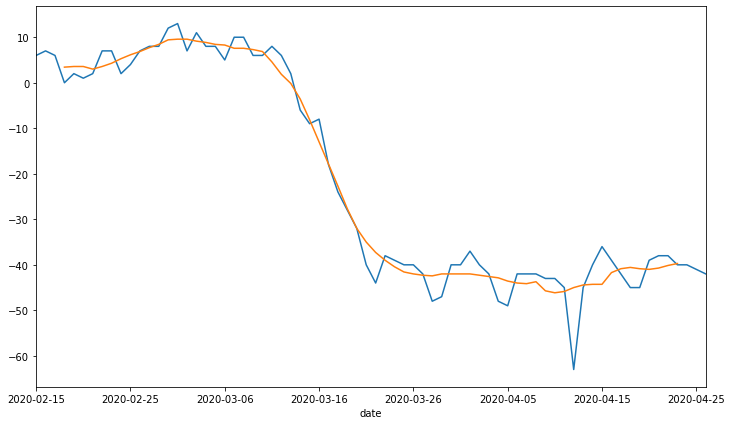

In [111]:
us_overall = united_states_mobility.iloc[np.where(united_states_mobility.sub_region_1.astype('str') == 'nan')]
us_overall = us_overall.set_index('date')
plt.figure(figsize = (12, 7))
us_overall.retail_and_recreation_percent_change_from_baseline.plot()

# Compute the centered 7-day rolling mean
us_overall_7d = us_overall[data_columns].rolling(7, center=True).mean()
# # Resample to weekly frequency, aggregating with mean
# # us_overall.index = pd.to_datetime(us_overall.index)
# # us_overall_weekly_mean = us_overall[data_columns].resample('W').mean()

# plt.figure(figsize = (12, 7))
# us_overall.retail_and_recreation_percent_change_from_baseline.plot(label = "Daily")
# # us_overall_weekly_mean.retail_and_recreation_percent_change_from_baseline.plot(label = "Weekly Mean Resample")
us_overall_7d.retail_and_recreation_percent_change_from_baseline.plot(label = '7-d Rolling Mean')
# plt.legend(loc = 'best')
# plt.show()

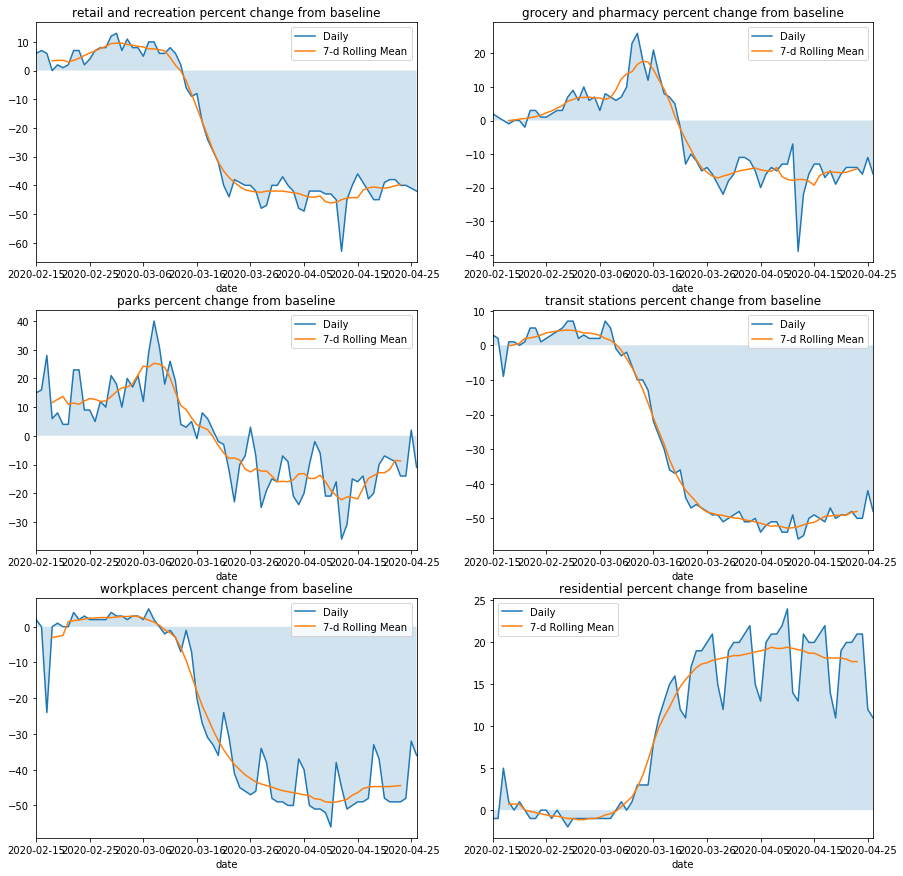

In [112]:
def plot_daily_rolling(df, col_name_lst):
    rolling_7d = df[col_name_lst].rolling(7, center=True).mean()
    
    fig, axes = plt.subplots(round(len(col_name_lst) / 2), 2, figsize = (15, 15))
    for i, col_name in enumerate(col_name_lst):
        df[col_name].plot(label = "Daily", ax = axes[i // 2][i % 2])
        rolling_7d[col_name].plot(label = '7-d Rolling Mean', ax = axes[i // 2][i % 2])
        axes[i // 2][i % 2].fill_between(df.index, 0, df[col_name], alpha = 0.2)
        axes[i // 2][i % 2].set_title(col_name.replace('_', " "))
        axes[i // 2][i % 2].legend(loc = 'best')
        
    plt.show()

        
plot_daily_rolling(us_overall, data_columns)


In [113]:
np.unique(united_states_mobility.iloc[np.where(united_states_mobility.sub_region_1.astype('str') == 'Washington')].sub_region_2.astype('str'))

array(['Adams County', 'Asotin County', 'Benton County', 'Chelan County',
       'Clallam County', 'Clark County', 'Cowlitz County',
       'Douglas County', 'Ferry County', 'Franklin County',
       'Grant County', 'Grays Harbor County', 'Island County',
       'Jefferson County', 'King County', 'Kitsap County',
       'Kittitas County', 'Klickitat County', 'Lewis County',
       'Lincoln County', 'Mason County', 'Okanogan County',
       'Pacific County', 'Pend Oreille County', 'Pierce County',
       'San Juan County', 'Skagit County', 'Skamania County',
       'Snohomish County', 'Spokane County', 'Stevens County',
       'Thurston County', 'Walla Walla County', 'Whatcom County',
       'Whitman County', 'Yakima County', 'nan'], dtype=object)

In [114]:
def get_county(state, county):
    all_counties = united_states_mobility.iloc[np.where(united_states_mobility.sub_region_1.astype('str') == state)]
    county_overall = all_counties.iloc[np.where(all_counties.sub_region_2.astype('str') == county)]
    county_overall = county_overall.set_index('date')
    return county_overall

def get_state_overall(state):
    return get_county(state, 'nan')

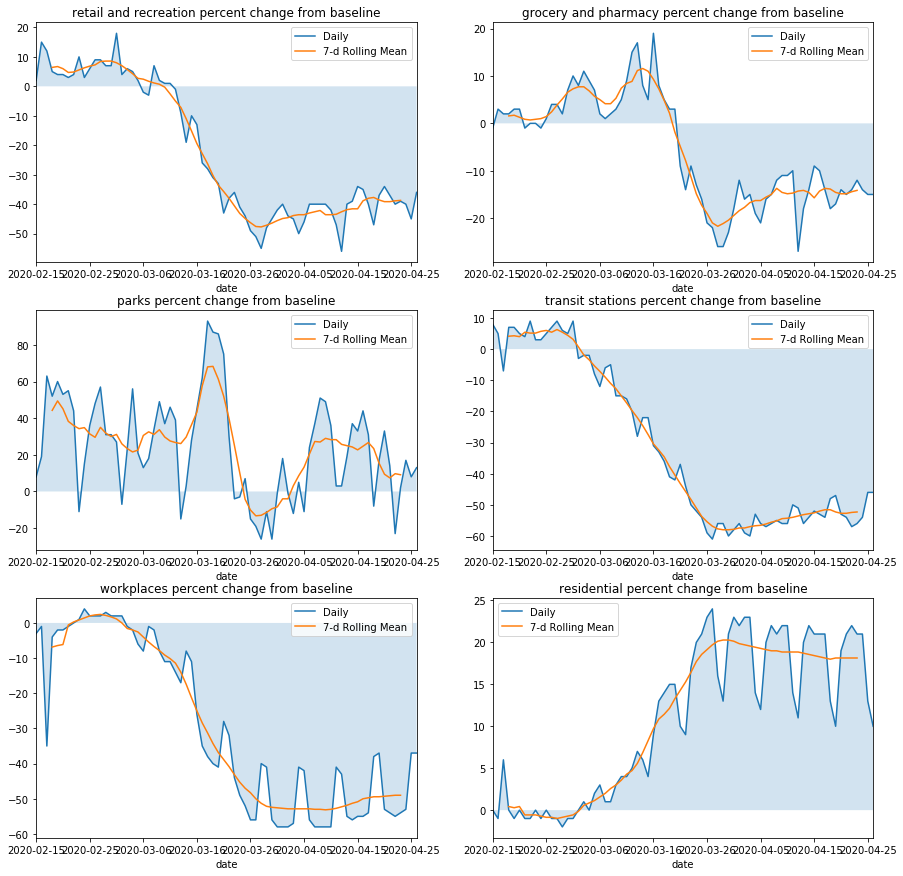

In [115]:
wa_overall = get_state_overall('Washington')
plot_daily_rolling(wa_overall, data_columns)

## SIR Model with Modifications

Basic SIR model: https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4

Variables in the SIR model:

- **N:** total population
- **S(t):** number of people susceptible on day *t*
- **E(t):** number of people exposed on day *t*
- **I(t):** number of people infected on day *t*
- **R(t):** number of people recovered on day *t*
- **D(t):** number of people dead on day *t*
- **$\mathbf{\beta}$:** expected amount of people an infected person infects per day
- **D:** number of days an infected person has and can spread the disease
- **$\mathbf{\gamma}$:** the proportion of infected recovering per day ($\gamma = 1 / D$)
- **R$_0$:** the total number of people an infected person infects ($R_0 = \beta / \gamma$)
- **$\mathbf{\delta}$:** length of incubation period
- **$\mathbf{\alpha}$:** fatality rate
- **$\mathbf{\rho}$:** rate at which people die ($\rho = 1 / $ days from infected until death)

In [116]:
def plotseird(t, S, E, I, R, D):
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
#     ax.axhline(1.12 * 10**6, t[0], t[-1], alpha=0.7, linewidth=1, label='current infected estimate')
#     ax.axhline(64867, t[0], t[-1], alpha=0.7, linewidth=1, label='current death estimate')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
#     ax.set_ylim((0, 1 * 10**7))
    plt.show();

In [117]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def deriv_original(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [118]:
us_overall_7d.iloc[3]

retail_and_recreation_percent_change_from_baseline     3.428571
grocery_and_pharmacy_percent_change_from_baseline      0.000000
parks_percent_change_from_baseline                    11.571429
transit_stations_percent_change_from_baseline         -0.142857
workplaces_percent_change_from_baseline               -3.000000
residential_percent_change_from_baseline               0.714286
Name: 2020-02-18, dtype: float64

In [119]:
L = 28 # day 0 = January 21, first day of Google mobility 7d rolling is Feb 18, 28 days later
N = 328.2 * 10**6 # Total population
# https://www.health.harvard.edu/diseases-and-conditions/if-youve-been-exposed-to-the-coronavirus
# mild infection seems to last one - two weeks, typically infectious 48 - 72 hours before showing symptoms
D = 14.0
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

# R_0 estimate https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
def R_0(t, initial_r_0, coefs, mobility_data):
    # Retail recreation - negative, harder to social distance
    # Grocery pharmacy - negative, easier to social distance
    # Parks - neutral, easier to social distance
    # Transit stations - negative, harder to social distance
    # Workplaces - negative, harder to social distance
    # Residential - positive, social distanced
    # R_0_change = (-)rr_coef * (% change from baseline) + (-)gp_coef * (% change from baseline) 
    #            + (-)p_coef * (% change from baseline) + (-)ts_coef * (% change from baseline) 
    #            + (-)w_coef * (% change from baseline) + (+)r_coef * (% change from baseline)
    # negative coef ranking: rr_coef >= ts_coef >= w_coef > gp_coef >= p_coef
#     r_0 = 5.7
#     coefs = [-1, -0.5, -0.5, -1, -1, 2]
    r_0 = initial_r_0
    r_0_change = 0
    # First day recorded, last day recorded
    # TODO - change hardcoded numbers to match model
    max_data_idx = len(mobility_data) - 4
    if t >= 28 and t <= (max_data_idx + 25):
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * mobility_data.iloc[int(t) - 25][col] / 100
        r_0 -= r_0_change
#         print(max(r_0, 0))
    elif t > (max_data_idx + 25):
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * mobility_data.iloc[max_data_idx][col] / 100
        r_0 -= r_0_change
    return max(r_0, 0) 

# for t in range(25, 100):
#     R_0(t)

def beta(t):
    return R_0(t, 5.7, [-1, -0.5, -0.5, -1, -1, 2], us_overall_7d) * gamma

alpha = 0.14  # 14% death rate (estimated from current worldwide statistics, we are taking the lower estimate 
# because there are probably a lot of asymptomatic cases that are not identified)
rho = 1 / 9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [120]:
t = np.linspace(0, 365, 366) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

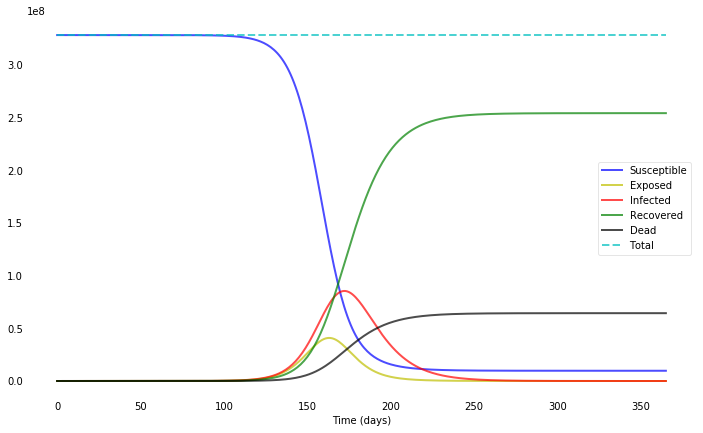

In [121]:
plotseird(t, S, E, I, R, D)

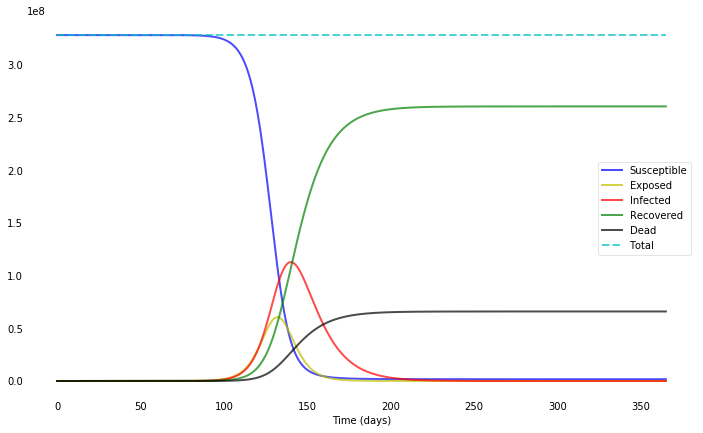

In [122]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_original, y0, t, args=(N, 5.7 * gamma, gamma, delta, alpha, rho))
S_orig, E_orig, I_orig, R_orig, D_orig = ret.T
plotseird(t, S_orig, E_orig, I_orig, R_orig, D_orig)

In [123]:
def plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax.plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax.plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax.plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax.plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax.plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

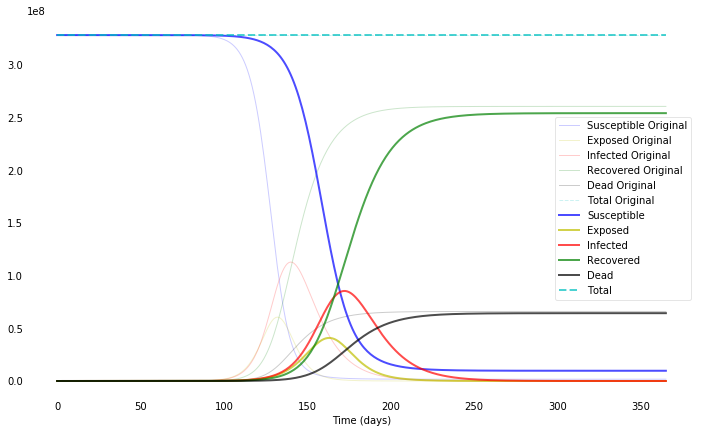

In [124]:
plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

In [125]:
def plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    f, ax = plt.subplots(3,2,figsize=(20,17))
    ax[2, 0].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 0].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[0, 0].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[0, 0].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[0, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[0, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[1, 0].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[1, 0].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[1, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[1, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')

    ax[2, 1].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 1].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[2, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[2, 1].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[2, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[2, 1].plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax[2, 1].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[2, 1].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[2, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[2, 1].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[2, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')
    ax[2, 1].plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    
    
    for a in ax:  
        for i in range(2):
            a[i].set_xlabel('Time (days)')
            a[i].yaxis.set_tick_params(length=0)
            a[i].xaxis.set_tick_params(length=0)
            a[i].grid(b=True, which='major', c='w', lw=2, ls='-')
            legend = a[i].legend()
            legend.get_frame().set_alpha(0.5)
            for spine in ('top', 'right', 'bottom', 'left'):
                a[i].spines[spine].set_visible(False)
    plt.show();

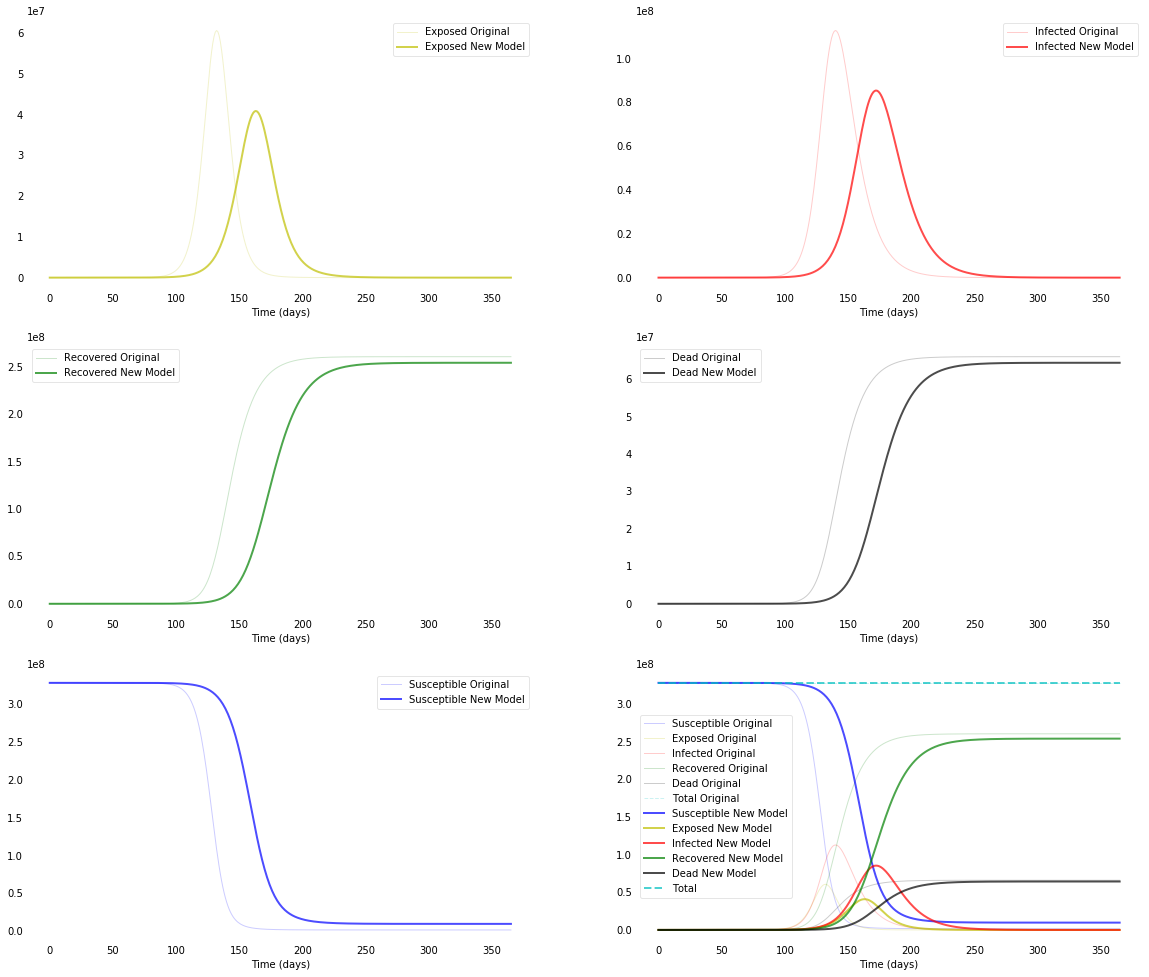

In [126]:
plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

## Apple Mobility Data SIR

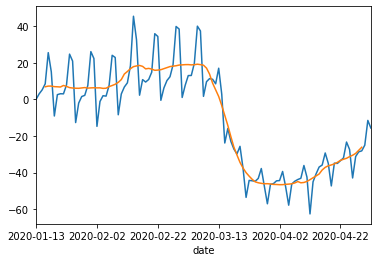

In [127]:
apple_mobility = pd.read_csv('data/applemobilitytrends-2020-05-02.csv') # will need to change this
apple_us = apple_mobility[apple_mobility['region'] == 'United States']

# NECESSARY DATA WRANGLING

data_columns = ['driving', 'transit', 'walking']

apple_us_total = apple_us[apple_us['geo_type'] == 'country/region']
transposed_apple = apple_us_total.drop(columns=['geo_type', 'region', 'alternative_name']).T
transposed_apple = transposed_apple.reset_index().rename(columns={'index': 'date', 146: 'driving', 147: 'transit', 148:'walking'}).iloc[1:]
transposed_apple = transposed_apple.set_index('date')

# centering to reflect how the google mobility data is structured
transposed_apple = transposed_apple - 100

us_overall_7d_apple = transposed_apple[data_columns].rolling(7, center=True).mean()

transposed_apple.driving.plot()
us_overall_7d_apple.driving.plot()

In [128]:
# THIS IS WHERE YOU TUNE PARAMETERS
def beta(t):
    return R_0(t, 5.7, [-1, -1, -1], us_overall_7d_apple) * gamma

alpha = 0.14  # 14% death rate (estimated from current worldwide statistics, we are taking the lower estimate 
# because there are probably a lot of asymptomatic cases that are not identified)
rho = 1 / 9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

t = np.linspace(0, 365, 366) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

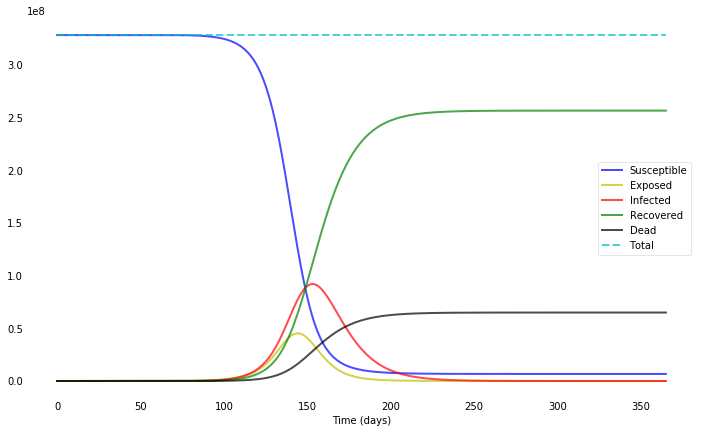

In [129]:
plotseird(t, S, E, I, R, D)

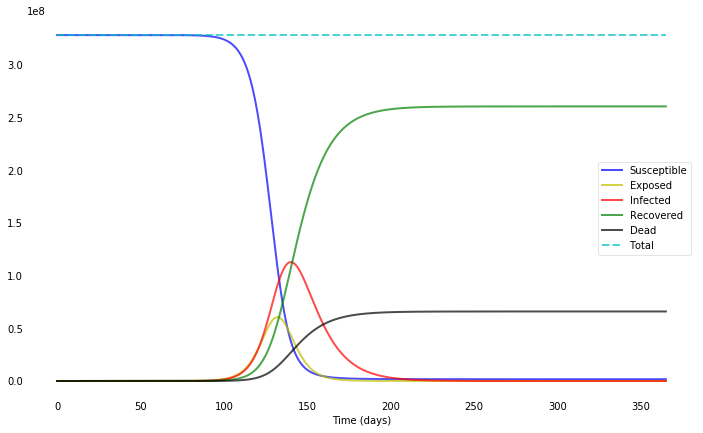

In [130]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_original, y0, t, args=(N, 5.7 * gamma, gamma, delta, alpha, rho))
S_orig, E_orig, I_orig, R_orig, D_orig = ret.T
plotseird(t, S_orig, E_orig, I_orig, R_orig, D_orig)

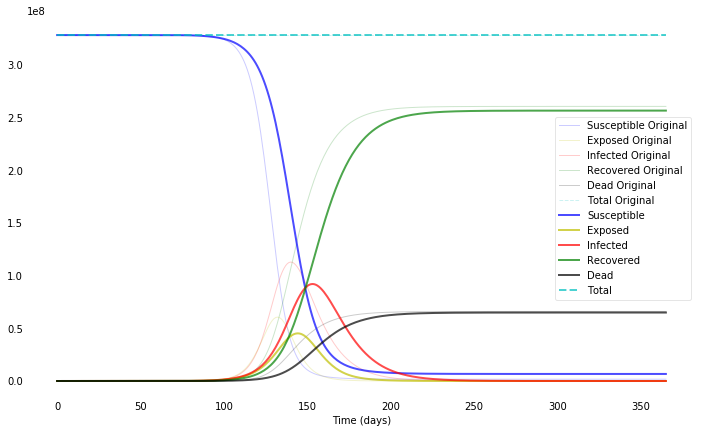

In [131]:
plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

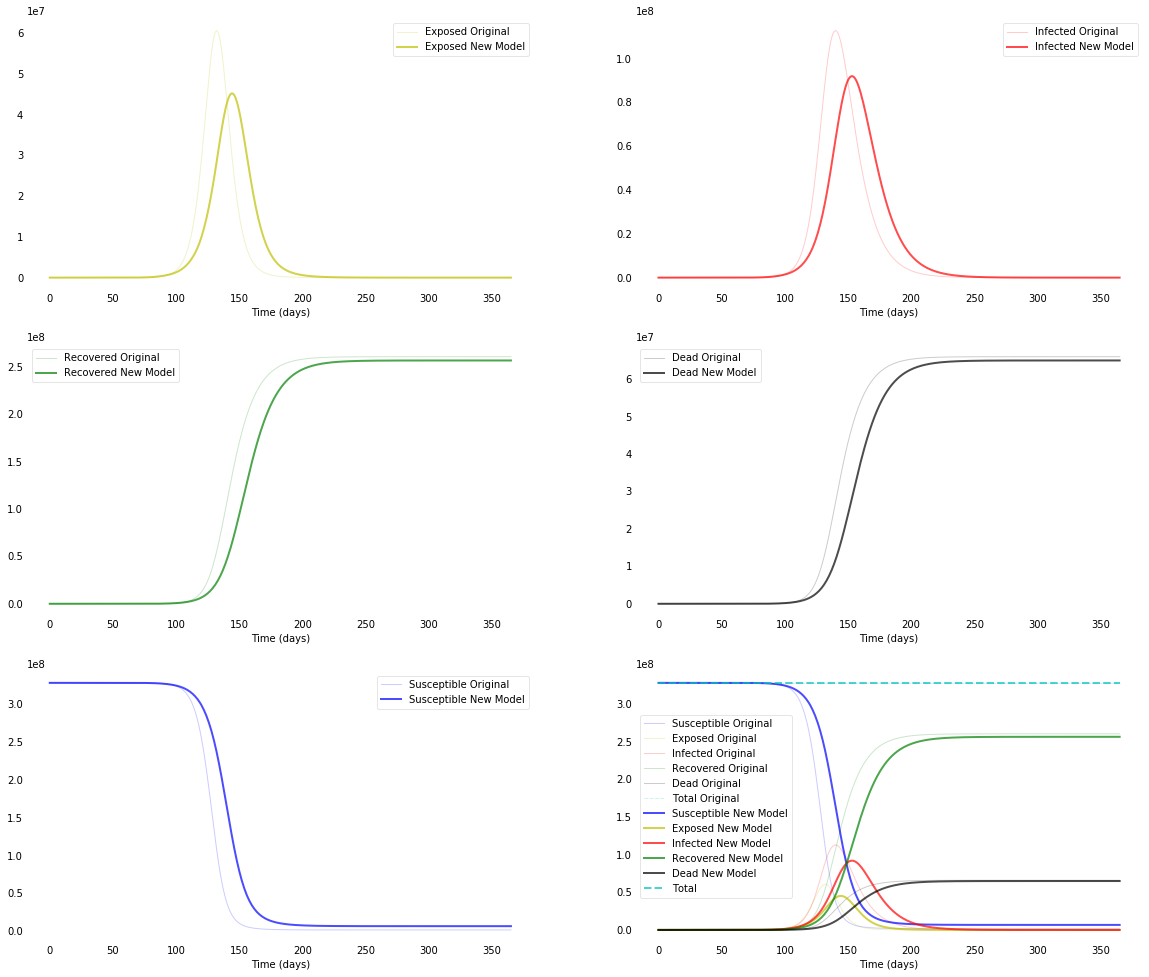

In [132]:
plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

## Model ideas

- Time series forecasting to extend the mobility data to predict/model the future and past
- Fine tune the parameter values
- Further adjust the $R_0$ function (maybe some type of logistic or dependent on past $R_0$)
- Add resource and age dependent fatality rates

# Seth Begins Fucking Around 

In [258]:
# Time Series - Global confirmed cases
ts_global_confirmed = pd.read_csv('../covid/data/CSSEGIS_COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
us_confirmed_full = ts_global_confirmed[ts_global_confirmed["Country/Region"] == "US"]


In [259]:
# Generate Dates, convert to string, then vectorize
drop_dates = pd.date_range(start='1/22/2020', end='2/14/2020').strftime("%-m/%-d/%y").to_numpy()

In [260]:
# us_confirmed = us_confirmed_full.drop(columns=drop_dates)
us_confirmed = us_confirmed_full.drop(columns = ["Province/State", "Country/Region", "Lat", "Long"])
us_confirmed = us_confirmed.to_numpy()[0]

In [261]:
# Time Series - US deaths
ts_US_deaths = pd.read_csv('../covid/data/CSSEGIS_COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
us_deaths_full = ts_US_deaths[ts_US_deaths["Country_Region"] == "US"]
us_deaths_full = us_deaths_full.drop(columns=["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", 
                                              "Province_State", "Country_Region",
                                              "Lat", "Long_", "Combined_Key", "Population"])
# us_deaths_full = us_deaths_full.drop(columns=drop_dates)
us_deaths = us_deaths_full.sum(axis = 0)


In [266]:
def plotseird_both_actual(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D, 
                   actual_confirmed=us_confirmed,
                   actual_deaths=us_deaths):
    f, ax = plt.subplots(1,1,figsize=(12,7))
#     ax.plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax.plot(t, E_orig, 'y', alpha=0.7, linewidth=1, label='Exposed Original')
    ax.plot(t, I_orig, 'r', alpha=0.7, linewidth=1, label='Infected Original')
    ax.plot(t, R_orig, 'g', alpha=0.7, linewidth=1, label='Recovered Original')
    ax.plot(t, D_orig, 'k', alpha=0.7, linewidth=1, label='Dead Original')
#     ax.plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
#     ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
#     ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.plot(t, actual_confirmed, 'b', alpha=0.7, linewidth=2, label='Actual Infected')
    ax.plot(t, actual_deaths, 'cyan', alpha=0.7, linewidth=2, label='Actual Deaths')


    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

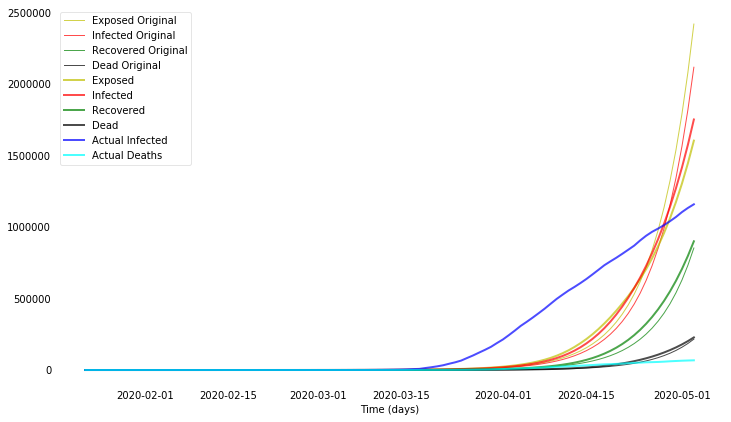

In [269]:
t=pd.date_range(start='1/22/2020', end='5/3/2020')
N = len(t)
plotseird_both_actual(t, S_orig[0:N], E_orig[0:N], I_orig[0:N], R_orig[0:N], D_orig[0:N], 
                      S[0:N], E[0:N], I[0:N], R[0:N], D[0:N])
